In [1]:
import os 
os.path.isfile("Tesla Data Set.zip")


True

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)


In [1]:
['Tesla Data Set.zip', ...]


['Tesla Data Set.zip', Ellipsis]

In [15]:
import zipfile

zip_path = "Tesla Data Set.zip"   # exact name from your error context
extract_path = "data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ ZIP extracted into /data folder")


✅ ZIP extracted into /data folder


In [17]:
import os

os.listdir("data")


['HistoricalData_1726367135218.csv', 'TSLA-2.csv', 'tsla_2025.csv']

In [19]:
from pathlib import Path
import pandas as pd

data_dir = Path("data")

csv_files = list(data_dir.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError("No CSV files found in data/")

file_path = csv_files[0]   # take the first CSV
df = pd.read_csv(file_path)

print("Loaded file:", file_path.name)
print("Shape:", df.shape)
df.head()


Loaded file: HistoricalData_1726367135218.csv
Shape: (2517, 6)


,Date,Close/Last,Volume,Open,High,Low
0,09/13/2024,$230.29,59515110,$228.00,$232.67,$226.32
1,09/12/2024,$229.81,72020040,$224.66,$231.45,$223.83
2,09/11/2024,$228.13,83548630,$224.55,$228.47,$216.8003
3,09/10/2024,$226.17,78891140,$220.07,$226.40,$218.6377
4,09/09/2024,$216.27,67443520,$216.20,$219.87,$213.67


In [21]:
# Clean column names
df.columns = [c.strip() for c in df.columns]

# Normalize Close/Last → Close
if "Close/Last" in df.columns:
    df = df.rename(columns={"Close/Last": "Close"})

# Detect date column
if "Date" not in df.columns:
    date_col = [c for c in df.columns if "date" in c.lower()][0]
    df = df.rename(columns={date_col: "Date"})

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# Clean numeric columns (handles $ and commas)
for c in df.columns:
    if c != "Date":
        df[c] = (
            df[c].astype(str)
            .str.replace("$", "", regex=False)
            .str.replace(",", "", regex=False)
        )
        df[c] = pd.to_numeric(df[c], errors="coerce")

df.head()


,Date,Close,Volume,Open,High,Low
0,2014-09-15,16.9240,246507477,18.2913,18.2933,16.6087
1,2014-09-16,17.3827,124461748,17.0100,17.4973,16.8280
2,2014-09-17,17.4253,77594871,17.4940,17.6467,17.3000
3,2014-09-18,17.5880,55342127,17.5573,17.7067,17.4880
4,2014-09-19,17.2880,102014574,17.1993,17.4287,17.0180


In [23]:
df.columns
df.tail()


,Date,Close,Volume,Open,High,Low
2512,2024-09-09,216.27,67443520,216.20,219.87,213.6700
2513,2024-09-10,226.17,78891140,220.07,226.40,218.6377
2514,2024-09-11,228.13,83548630,224.55,228.47,216.8003
2515,2024-09-12,229.81,72020040,224.66,231.45,223.8300
2516,2024-09-13,230.29,59515110,228.00,232.67,226.3200


In [25]:
import numpy as np
import pandas as pd

# Ensure correct order
df = df.sort_values("Date").reset_index(drop=True)

# Set Date as index (time-series best practice)
df.set_index("Date", inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-09-15 to 2024-09-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2517 non-null   float64
 1   Volume  2517 non-null   int64  
 2   Open    2517 non-null   float64
 3   High    2517 non-null   float64
 4   Low     2517 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 118.0 KB


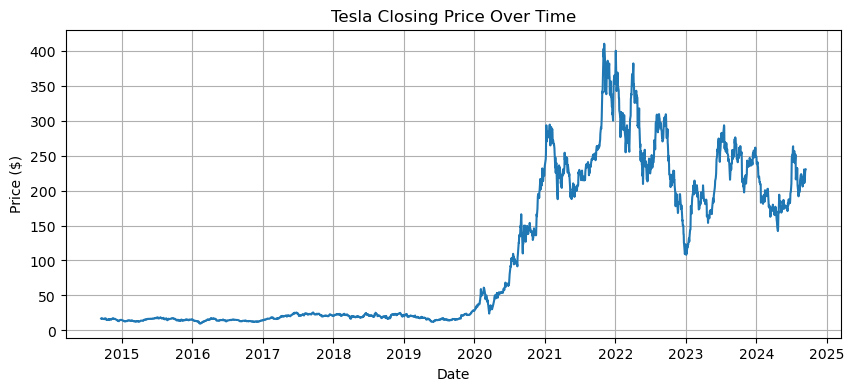

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Close"])
plt.title("Tesla Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()


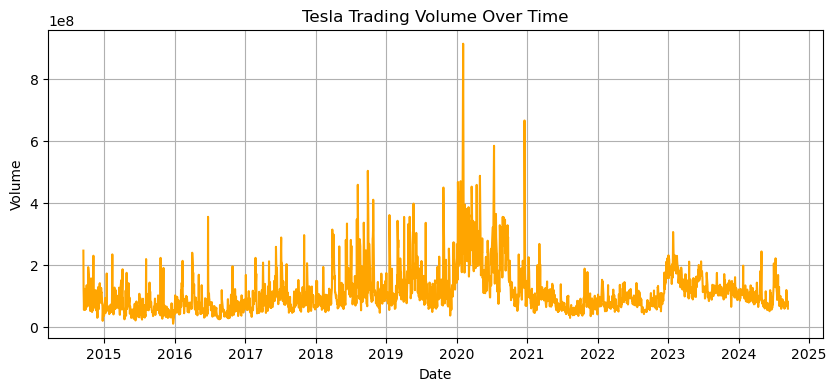

In [29]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Volume"], color="orange")
plt.title("Tesla Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.show()


In [31]:
# Returns
df["daily_return"] = df["Close"].pct_change()
df["log_return"] = np.log(df["Close"]).diff()

# Rolling volatility
df["vol_5"] = df["log_return"].rolling(5).std()
df["vol_10"] = df["log_return"].rolling(10).std()
df["vol_20"] = df["log_return"].rolling(20).std()

df[["daily_return", "vol_5", "vol_10", "vol_20"]].tail()


,daily_return,vol_5,vol_10,vol_20
Date,,,,
2024-09-09,0.026290,0.056313,0.041870,0.039448
2024-09-10,0.045776,0.057917,0.042676,0.040260
2024-09-11,0.008666,0.055960,0.041774,0.038901
2024-09-12,0.007364,0.051456,0.040835,0.037957
2024-09-13,0.002089,0.017562,0.040847,0.035698


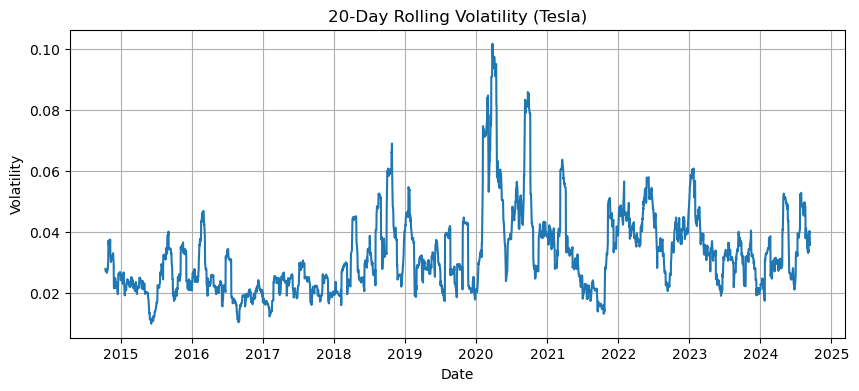

In [33]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["vol_20"])
plt.title("20-Day Rolling Volatility (Tesla)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()


In [35]:
# Moving averages
df["sma_10"] = df["Close"].rolling(10).mean()
df["sma_20"] = df["Close"].rolling(20).mean()
df["sma_50"] = df["Close"].rolling(50).mean()

# Momentum
df["momentum_5"] = df["Close"] / df["Close"].shift(5) - 1
df["momentum_10"] = df["Close"] / df["Close"].shift(10) - 1

df[["sma_10","sma_20","sma_50","momentum_5"]].tail()


,sma_10,sma_20,sma_50,momentum_5
Date,,,,
2024-09-09,213.574,213.5385,223.5394,0.010088
2024-09-10,214.870,214.9725,224.1052,0.073932
2024-09-11,216.762,215.9875,224.4706,0.039743
2024-09-12,219.168,217.4090,224.4416,-0.001564
2024-09-13,221.569,218.2165,224.1196,0.092820


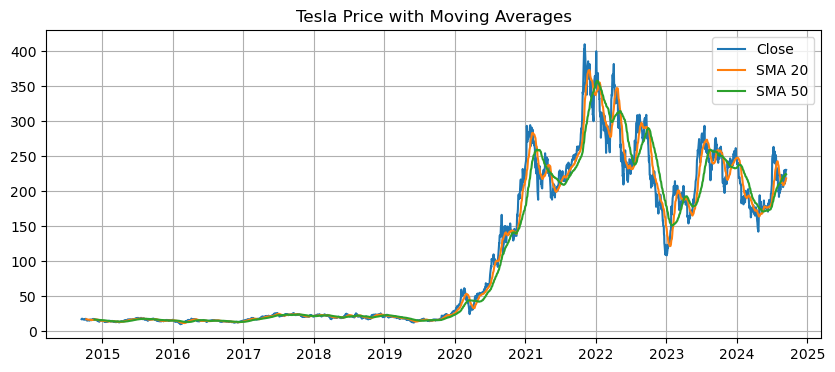

In [37]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Close"], label="Close")
plt.plot(df.index, df["sma_20"], label="SMA 20")
plt.plot(df.index, df["sma_50"], label="SMA 50")
plt.legend()
plt.title("Tesla Price with Moving Averages")
plt.grid(True)
plt.show()


In [39]:
# Regression target
df["target_next_return"] = df["Close"].shift(-1) / df["Close"] - 1

# Classification target (high risk day)
vol_threshold = df["vol_20"].quantile(0.75)
df["target_high_risk"] = (df["vol_20"].shift(-1) > vol_threshold).astype(int)

df[["target_next_return", "target_high_risk"]].tail()


,target_next_return,target_high_risk
Date,,
2024-09-09,0.045776,1
2024-09-10,0.008666,0
2024-09-11,0.007364,0
2024-09-12,0.002089,0
2024-09-13,NaN,0


In [41]:
df_ml = df.dropna()

features = [
    "daily_return","vol_5","vol_10","vol_20",
    "sma_10","sma_20","sma_50",
    "momentum_5","momentum_10",
    "Volume"
]

X = df_ml[features]
y_reg = df_ml["target_next_return"]
y_clf = df_ml["target_high_risk"]

print("Final dataset shape:", X.shape)


Final dataset shape: (2467, 10)


In [43]:
split = int(len(df_ml) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_reg_train, y_reg_test = y_reg.iloc[:split], y_reg.iloc[split:]
y_clf_train, y_clf_test = y_clf.iloc[:split], y_clf.iloc[split:]

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1973, 10) Test: (494, 10)


In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score

# Baseline Regression
reg_base = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

# Baseline Classification
clf_base = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=3000))
])

reg_base.fit(X_train, y_reg_train)
clf_base.fit(X_train, y_clf_train)

pred_ret_base = reg_base.predict(X_test)
prob_risk_base = clf_base.predict_proba(X_test)[:, 1]

print("✅ BASELINE — Regression (Next-day return)")
print("MAE :", mean_absolute_error(y_reg_test, pred_ret_base))
print("RMSE:", mean_squared_error(y_reg_test, pred_ret_base, squared=False))
print("R2  :", r2_score(y_reg_test, pred_ret_base))

print("\n✅ BASELINE — Classification (High-risk day)")
print("AUC :", roc_auc_score(y_clf_test, prob_risk_base))


✅ BASELINE — Regression (Next-day return)
MAE : 0.026943998162088593
RMSE: 0.03636043940854764
R2  : 0.0073979976805513825

✅ BASELINE — Classification (High-risk day)
AUC : 0.9750329314013578


C:\Users\harik\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [47]:
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier

reg_adv = ExtraTreesRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)

clf_adv = ExtraTreesClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)

reg_adv.fit(X_train, y_reg_train)
clf_adv.fit(X_train, y_clf_train)

pred_ret_adv = reg_adv.predict(X_test)
prob_risk_adv = clf_adv.predict_proba(X_test)[:, 1]
pred_risk_adv = (prob_risk_adv >= 0.5).astype(int)

print("✅ ADVANCED — Regression (ExtraTrees)")
print("MAE :", mean_absolute_error(y_reg_test, pred_ret_adv))
print("RMSE:", mean_squared_error(y_reg_test, pred_ret_adv, squared=False))
print("R2  :", r2_score(y_reg_test, pred_ret_adv))

print("\n✅ ADVANCED — Classification (ExtraTrees)")
print("AUC :", roc_auc_score(y_clf_test, prob_risk_adv))


✅ ADVANCED — Regression (ExtraTrees)
MAE : 0.02834881690329349
RMSE: 0.038209261483113766
R2  : -0.09611012217385029

✅ ADVANCED — Classification (ExtraTrees)
AUC : 0.9621846185023811


C:\Users\harik\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


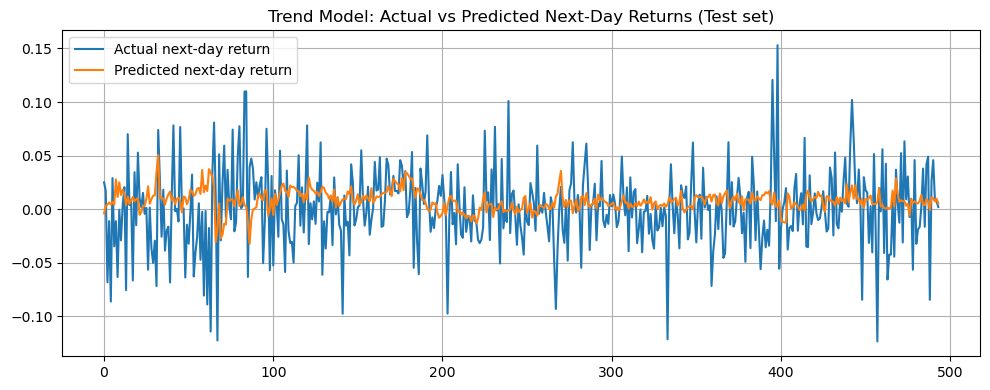

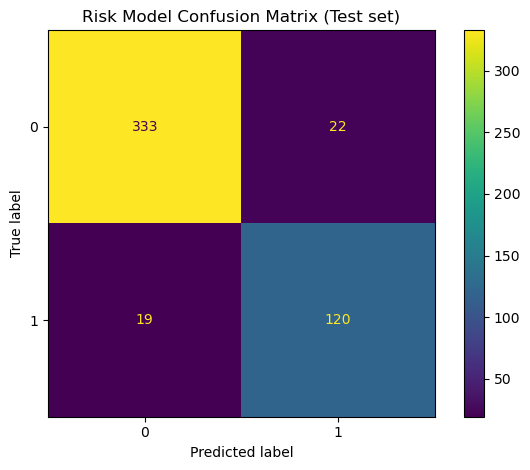

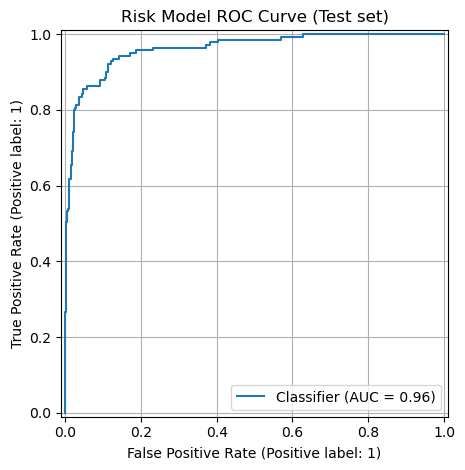

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# 1) Actual vs predicted (regression)
plt.figure(figsize=(10,4))
plt.plot(y_reg_test.values, label="Actual next-day return")
plt.plot(pred_ret_adv, label="Predicted next-day return")
plt.title("Trend Model: Actual vs Predicted Next-Day Returns (Test set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Confusion matrix (classification)
cm = confusion_matrix(y_clf_test.values, pred_risk_adv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("Risk Model Confusion Matrix (Test set)")
plt.tight_layout()
plt.show()

# 3) ROC curve (classification)
RocCurveDisplay.from_predictions(y_clf_test.values, prob_risk_adv)
plt.title("Risk Model ROC Curve (Test set)")
plt.grid(True)
plt.tight_layout()
plt.show()


Top 10 features driving RETURN prediction:


Volume          0.117339
momentum_10     0.113960
vol_5           0.112485
momentum_5      0.111819
daily_return    0.109164
vol_20          0.102181
vol_10          0.096749
sma_10          0.082223
sma_50          0.077150
sma_20          0.076930
dtype: float64

Top 10 features driving RISK prediction:


vol_20          0.405150
vol_10          0.197402
vol_5           0.103646
sma_50          0.082695
sma_10          0.063156
sma_20          0.060458
Volume          0.027468
momentum_10     0.025642
momentum_5      0.021910
daily_return    0.012472
dtype: float64

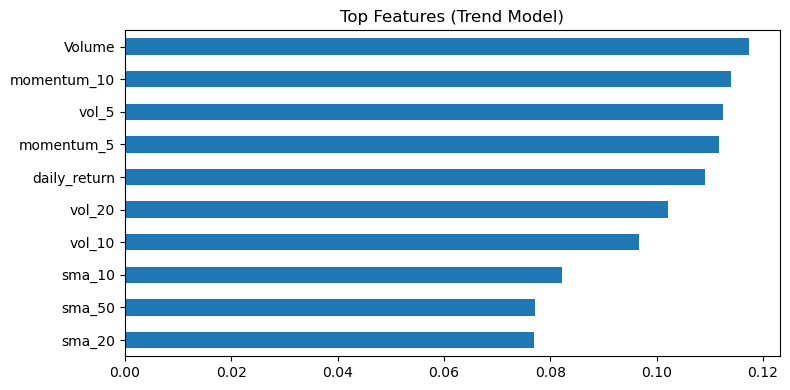

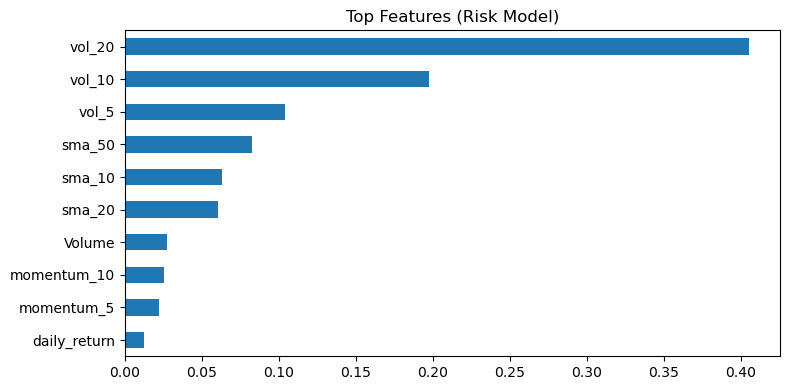

In [51]:
import pandas as pd

imp_reg = pd.Series(reg_adv.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_clf = pd.Series(clf_adv.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("Top 10 features driving RETURN prediction:")
display(imp_reg.head(10))

print("Top 10 features driving RISK prediction:")
display(imp_clf.head(10))

# Plot top features for regression
plt.figure(figsize=(8,4))
imp_reg.head(10).sort_values().plot(kind="barh")
plt.title("Top Features (Trend Model)")
plt.tight_layout()
plt.show()

# Plot top features for classification
plt.figure(figsize=(8,4))
imp_clf.head(10).sort_values().plot(kind="barh")
plt.title("Top Features (Risk Model)")
plt.tight_layout()
plt.show()


✅ WALK-FORWARD REGRESSION RESULTS (more realistic than one split)
MAE : 0.029208438926117426
RMSE: 0.03940862161353935
R2  : -0.08091046621721909


C:\Users\harik\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


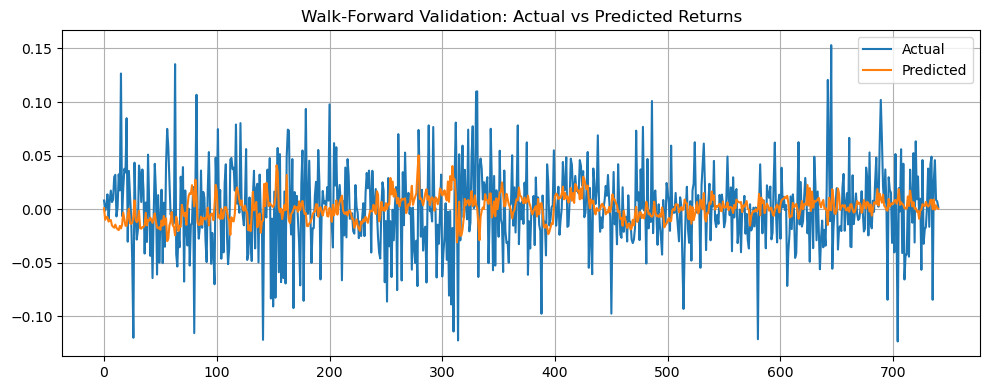

In [53]:
from sklearn.base import clone

def walk_forward_regression(model, X, y, initial_train_frac=0.7, step=50):
    n = len(X)
    start = int(n * initial_train_frac)
    preds, actuals = [], []

    for i in range(start, n, step):
        X_tr, y_tr = X.iloc[:i], y.iloc[:i]
        X_te, y_te = X.iloc[i:i+step], y.iloc[i:i+step]
        if len(X_te) == 0:
            break

        m = clone(model)
        m.fit(X_tr, y_tr)
        p = m.predict(X_te)

        preds.append(p)
        actuals.append(y_te.values)

    return np.concatenate(actuals), np.concatenate(preds)

# Use entire df_ml (not just test) for walk-forward
actual_wf, pred_wf = walk_forward_regression(
    ExtraTreesRegressor(n_estimators=400, random_state=42, n_jobs=-1, min_samples_leaf=2),
    X, y_reg, initial_train_frac=0.7, step=50
)

print("✅ WALK-FORWARD REGRESSION RESULTS (more realistic than one split)")
print("MAE :", mean_absolute_error(actual_wf, pred_wf))
print("RMSE:", mean_squared_error(actual_wf, pred_wf, squared=False))
print("R2  :", r2_score(actual_wf, pred_wf))

plt.figure(figsize=(10,4))
plt.plot(actual_wf, label="Actual")
plt.plot(pred_wf, label="Predicted")
plt.title("Walk-Forward Validation: Actual vs Predicted Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


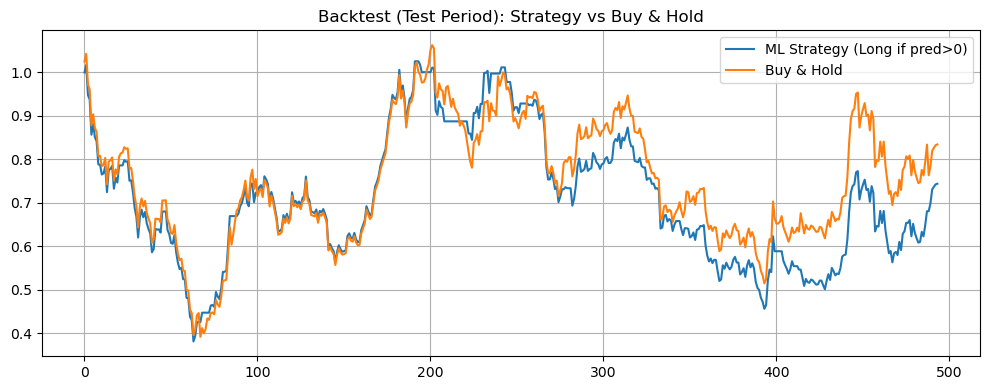

Final cumulative return (Strategy): 0.7439127502508031
Final cumulative return (Buy & Hold): 0.8343538277598632

Strategy avg daily return: -1.4622332547246721e-05
Strategy daily volatility: 0.03416702370709946


In [55]:
# Strategy: go long if predicted return > 0, else stay out (0)
signal = (pred_ret_adv > 0).astype(int)

strategy_ret = signal * y_reg_test.values
buy_hold_ret = y_reg_test.values

cum_strategy = np.cumprod(1 + strategy_ret)
cum_buyhold  = np.cumprod(1 + buy_hold_ret)

plt.figure(figsize=(10,4))
plt.plot(cum_strategy, label="ML Strategy (Long if pred>0)")
plt.plot(cum_buyhold, label="Buy & Hold")
plt.title("Backtest (Test Period): Strategy vs Buy & Hold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Final cumulative return (Strategy):", float(cum_strategy[-1]))
print("Final cumulative return (Buy & Hold):", float(cum_buyhold[-1]))

# Optional: basic risk stats
print("\nStrategy avg daily return:", float(np.mean(strategy_ret)))
print("Strategy daily volatility:", float(np.std(strategy_ret)))


In [57]:
import joblib

joblib.dump(reg_adv, "tsla_trend_model_expert.joblib")
joblib.dump(clf_adv, "tsla_risk_model_expert.joblib")

print("✅ Saved:")
print(" - tsla_trend_model_expert.joblib")
print(" - tsla_risk_model_expert.joblib")


✅ Saved:
 - tsla_trend_model_expert.joblib
 - tsla_risk_model_expert.joblib
